In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

In [2]:
all_seasons = []

for season in range(2021, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
Successfully fetched data for season 2023-2024
      playerId     skaterFullName positionCode  gamesPlayed  otGoals  \
0      8465009        Zdeno Chara            D           72        0   
1      8466138       Joe Thornton            C           34        0   
2      8469455       Jason Spezza            C           71        0   
3      8470281       Duncan Keith            D           64        0   
4      8470595         Eric Staal            C           72        0   
...        ...                ...          ...          ...      ...   
1250   8484314       Jiri Smejkal            L           20        0   
1251   8484321  Nikolas Matinpalo            D            4        0   
1252   8484325    Waltteri Merela            C           19        0   
1253   8484326        Patrik Koch            D            1        0   
1254   8484911        Collin Graf            R            7        

In [3]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [4]:
goals_up_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [5]:
urls = {
    "goals_up_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_up_by_one'),
    "goals_down_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_down_by_one'),
    "tied": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_when_tied'),
    "total": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'total_goals')
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [6]:
total_df.columns

Index(['Player', 'Team', 'Position', 'GP', 'TOI', 'total_goals',
       'Total Assists', 'First Assists', 'Second Assists', 'Total Points',
       'IPP', 'Shots', 'SH%', 'ixG', 'iCF', 'iFF', 'iSCF', 'iHDCF',
       'Rush Attempts', 'Rebounds Created', 'PIM', 'Total Penalties', 'Minor',
       'Major', 'Misconduct', 'Penalties Drawn', 'Giveaways', 'Takeaways',
       'Hits', 'Hits Taken', 'Shots Blocked', 'Faceoffs Won', 'Faceoffs Lost',
       'Faceoffs %'],
      dtype='object')

In [7]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

import functools as ft
merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)
merged_natural_stat.rename(columns={'Rush Attempts': 'rush_attempts'}, inplace=True)
merged_natural_stat['non_clutch_goals'] = merged_natural_stat['total_goals'] - (merged_natural_stat['goals_up_by_one'] + merged_natural_stat['goals_down_by_one'] + merged_natural_stat['goals_when_tied']) 

In [8]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [9]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rush_attempts,non_clutch_goals
1,Jason Spezza,71,2,4,1,12,97,9.20,131,83,33,8,5
2,Eric Staal,72,3,2,3,14,106,12.99,142,119,65,8,6
3,Jeff Carter,227,12,10,9,43,429,48.99,563,412,221,33,12
4,Dustin Brown,64,1,2,2,9,146,15.64,196,129,65,6,4
5,Zach Parise,194,3,6,12,41,370,50.43,472,406,239,22,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,Juraj Slafkovsky,121,2,5,6,24,194,25.41,287,243,113,7,11
764,Ben Meyers,67,0,1,2,6,54,7.86,81,69,44,4,3
769,Andrei Kuzmenko,153,8,13,18,61,264,41.21,407,391,216,9,22
772,Connor Bedard,68,2,6,9,22,206,23.82,299,226,69,17,5


In [10]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,ot_goals,game_winning_goals,regulation_game_winning
0,8469455,Jason Spezza,C,71,0,1,1
1,8470595,Eric Staal,C,72,0,1,1
2,8470604,Jeff Carter,C,227,2,8,6
3,8470606,Dustin Brown,R,64,0,0,0
4,8470610,Zach Parise,L,194,1,7,6
...,...,...,...,...,...,...,...
508,8483515,Juraj Slafkovsky,L,121,0,2,2
509,8483570,Ben Meyers,C,67,0,0,0
510,8483808,Andrei Kuzmenko,L,153,3,8,5
511,8484144,Connor Bedard,C,68,1,2,1


In [11]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [12]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,ot_goals,game_winning_goals,regulation_game_winning,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rush_attempts,non_clutch_goals
0,8469455,Jason Spezza,C,71,0,1,1,71,2,4,1,12,97,9.20,131,83,33,8,5
1,8470595,Eric Staal,C,72,0,1,1,72,3,2,3,14,106,12.99,142,119,65,8,6
2,8470604,Jeff Carter,C,227,2,8,6,227,12,10,9,43,429,48.99,563,412,221,33,12
3,8470606,Dustin Brown,R,64,0,0,0,64,1,2,2,9,146,15.64,196,129,65,6,4
4,8470610,Zach Parise,L,194,1,7,6,194,3,6,12,41,370,50.43,472,406,239,22,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,8483515,Juraj Slafkovsky,L,121,0,2,2,121,2,5,6,24,194,25.41,287,243,113,7,11
509,8483570,Ben Meyers,C,67,0,0,0,67,0,1,2,6,54,7.86,81,69,44,4,3
510,8483808,Andrei Kuzmenko,L,153,3,8,5,153,8,13,18,61,264,41.21,407,391,216,9,22
511,8484144,Connor Bedard,C,68,1,2,1,68,2,6,9,22,206,23.82,299,226,69,17,5


In [13]:
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, ot_goals, game_winning_goals, regulation_game_winning, GP, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, rush_attempts, non_clutch_goals]
Index: []


In [14]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)

In [15]:
columns = ['ot_goals', 'regulation_game_winning', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'non_clutch_goals', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


In [16]:
merged_clutch_goals['clutch_score'] =  0.25 * merged_clutch_goals['goals_when_tied_per_game'] + 0.25 * merged_clutch_goals['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals['goals_up_by_one_per_game'] + 0.15 * merged_clutch_goals['ot_goals_per_game'] + 0.15 * merged_clutch_goals['regulation_game_winning'] 

In [17]:
merged_clutch_goals['clutch_score'] *= 10
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False)
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
222,Leon Draisaitl,38.54,1.0
236,David Pastrnak,34.17,2.0
274,Sebastian Aho,33.90,3.0
245,Brayden Point,33.85,4.0
318,Auston Matthews,32.76,5.0
264,Kyle Connor,32.41,6.0
72,Chris Kreider,29.34,7.0
16,Sidney Crosby,29.30,8.0
385,Jason Robertson,29.30,9.0
267,Connor McDavid,28.03,10.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


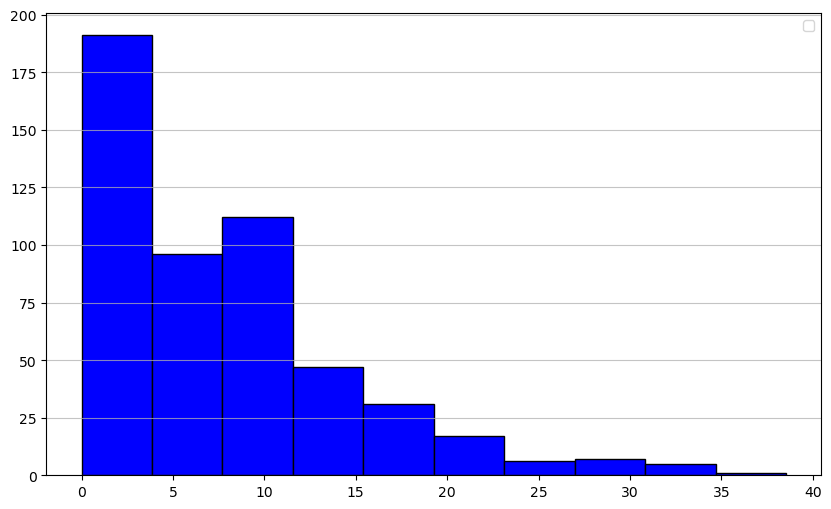

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

In [19]:
threshold = merged_clutch_goals['clutch_score'].quantile(0.85)

def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

In [20]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    435
1     78
Name: count, dtype: int64